# COMP-767: Reinforcement Learning - Assignment 2

## 1.Prediction and control in RL [50 points] 

In this task, you will compare the performance of SARSA, expected SARSA and Q-learningon the Taxi domain from the Gym environment suite:https://gym.openai.com/envs/Taxi-v2/ 
 
 Use a tabular representation of the state space, and ensure that the starting and end location of the passenger are random. Exploration should be softmax (Boltzmann).  You will need to run the following protocol.  You will do 10 independent runs.  Each run consists of 100 segments, in each segment there are 10 episodes of training, followed by 1 episode in which you simply run the optimal policy so far (i.e. you pick actions greedily based on the current value estimates). Pick 3 settings of the temperature parameter used in the exploration and 3 settings of the learning rate. 
 
 You need to plot:
 
* One u-shaped graph that shows the effect of the parameters on the final training perfor-mance, expressed as the return of the agent (averaged over the last 10 training episodesand the 10 runs); note that this will typically end up as an upside-down u.
 
* One u-shaped graph that shows the effect of the parameters on the final testing perfor-mance, expressed as the return of the agent (during the final testing episode, averagedover the 10 runs)
 
* Learning curves (mean and standard deviation computed based on the 10 runs) for whatyou pick as the best parameter setting for each algorithmWrite a small report that describes your experiment,  your choices of parameters,  and theconclusions you draw from the graphs.

In [1]:
%load_ext autoreload
%autoreload 2

import gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys
from multiprocessing import Pool

import temporal_difference

In [2]:
def get_q(env):
    num_actions = 6
    num_states = 5*5*5*4
    q = {state: np.random.rand(num_actions) for state in range(num_states)}

    for loc_id in range(len(env.locs)):
        loc = env.locs[loc_id]
        s = env.encode(loc[0], loc[1], loc_id, loc_id)
        q[s] = np.zeros(num_actions)
    
    return q

In [3]:
def test_optimal_policy(q, env, discount_rate=0.9, show=True):
    policy_greedy = temporal_difference.Greedy(n=6)
    s = env.reset()
    a = policy_greedy.get_action(q, s)
    history = temporal_difference.History(s, a, discount_rate)
    done = False
    
    if show : 
        env.render()
        
    while not done:
        observation, reward, done, info = env.step(a)
        s = observation
        a = policy_greedy.get_action(q, s)
        history.register(s, a, reward)
        if show : 
            env.render()
            print(f"Timestep: {history.t}, Reward: {reward}, Total reward: {history.undiscounted_return()}, Discounted reward: {history.discounted_return()}")
    return history

In [4]:
def run(update_algorithm, temperature_factor=1, learning_rate=0.5, show=False, print_segment=False):
    n_segment=100
    episode_by_segment=10
    discount_rate = 0.9
    exploration_policy = temporal_difference.SoftmaxExploration(temperature_factor=temperature_factor)
    env = gym.make('Taxi-v2')
    q = get_q(env.unwrapped)
    
    last_training_results=[]
    for segment in range(n_segment):
        for episode in range(episode_by_segment):
            episode_history = update_algorithm(env, exploration_policy, q, learning_rate, discount_rate)
            
            if segment == n_segment - 1:
                last_training_results.append(episode_history.undiscounted_return())
        
        optimal_history = test_optimal_policy(q, env, discount_rate, show)
        
        if print_segment:
            print("Segment : %2i, Timestep : %3i, Total reward : %5i" % (segment, 
                                                                         optimal_history.t, 
                                                                         optimal_history.undiscounted_return()))
    return last_training_results, optimal_history.undiscounted_return()


run(temporal_difference.qlearning_update, print_segment=True)

Segment :  0, Timestep : 200, Total reward :  -200
Segment :  1, Timestep : 200, Total reward :  -200
Segment :  2, Timestep : 200, Total reward :  -200
Segment :  3, Timestep : 200, Total reward :  -200
Segment :  4, Timestep : 200, Total reward :  -200
Segment :  5, Timestep : 200, Total reward :  -200
Segment :  6, Timestep : 200, Total reward :  -200
Segment :  7, Timestep : 200, Total reward :  -200
Segment :  8, Timestep : 200, Total reward :  -200
Segment :  9, Timestep : 200, Total reward :  -200
Segment : 10, Timestep : 200, Total reward :  -200
Segment : 11, Timestep : 200, Total reward :  -200
Segment : 12, Timestep : 200, Total reward :  -200
Segment : 13, Timestep : 200, Total reward :  -200
Segment : 14, Timestep : 200, Total reward :  -200
Segment : 15, Timestep : 200, Total reward :  -200
Segment : 16, Timestep : 200, Total reward :  -200
Segment : 17, Timestep : 200, Total reward :  -200
Segment : 18, Timestep : 200, Total reward :  -200
Segment : 19, Timestep : 200, T

([12, 7, 10, 6, 11, 8, -1, 14, 13, 1], 9)

In [ ]:
def parameters_effect(update_algorithm, temparature_factor, learning_rate):
    n_run = 10
    training_results = np.zeros((n_run, 10))
    testing_results = np.zeros(n_run)
    for i in range(n_run):
        training_results[i,:], testing_results[i] = run(update_algorithm, temparature_factor, learning_rate)
    final_training_performance = (np.mean(training_results), np.std(training_results))
    final_testing_performance = (np.mean(testing_results),np.std(testing_results))
    return final_training_performance, final_testing_performance

In [ ]:
def subplot(name, algo, results, learning_rates, temperature_factors):
    for i in range(len(results)):
        plt.plot(learning_rates, results[i], label=temperature_factors[i])
    plt.legend()
    plt.title(algo + " during " + name)
    plt.xlabel("learning rate")
    plt.ylabel("Cumulative reward")
    
def plot(algo, train, test, learning_rates, temperature_factors):
    fig = plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    subplot("training", algo, train, learning_rates, temperature_factors)

    plt.subplot(1, 2, 2)
    subplot("testing", algo, test, learning_rates, temperature_factors)
    plt.show()

In [ ]:
def algorithm_parameters_effect(update_algorithm, learning_rates, temperature_factors):
    print(update_algorithm)
    sys.stdout.flush()
    train_results, test_results=[],[]
    for temparature_factor in tqdm(temperature_factors):
        partial_train_results, partial_test_results = [],[]
        for learning_rate in learning_rates:
            train, test = parameters_effect(algorithms[update_algorithm], temparature_factor, learning_rate)
            partial_train_results.append(train[0])
            partial_test_results.append(test[0])
        train_results.append(partial_train_results)
        test_results.append(partial_test_results)
    plot(update_algorithm, train_results, test_results, learning_rates, temperature_factors)

## too slow
# for algo in algorithms:
#     algorithm_parameters_effect(algo, learning_rate_settings, temperature_parameter_settings)

SARSA


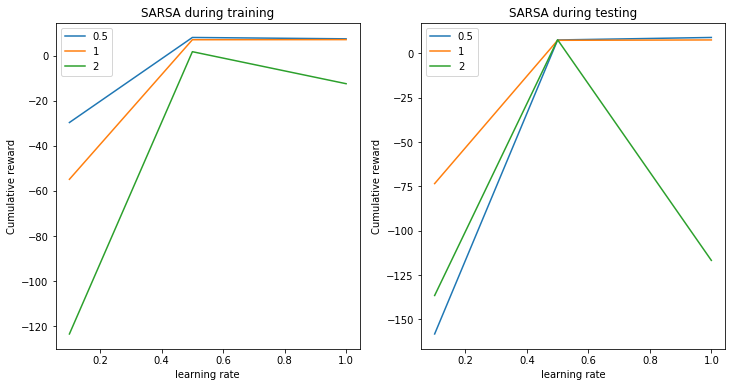

Best return : 9.0, with std :2.4083189157584592, learning rate = 1, and temperature factor = 0.5 

Expected SARSA


In [ ]:
def break_list(data, len_sub):
        return [data[x:x+len_sub] for x in range(0, len(data), len_sub)]

def get_means(results):
    return [[m for m, std in r] for r in results]

def get_best(results, learning_rates, temperature_factors):
    best_reward = -10000
    best_lr = -1
    best_tf = -1
    for r in results:
        means = [m for m, std in r]
        stds = [std for m, std in r]
        if max(means) > best_reward:
            best_reward = max(means)
            best_std = stds[np.argmax(means)]
            best_lr = learning_rates[np.argmax(means)]
            best_tf = temperature_factors[results.index(r)]
    return best_reward, best_std, best_lr, best_tf

def algorithm_parameters_effect_parallel(update_algorithm, learning_rates, temperature_factors):
    print(update_algorithm)
    sys.stdout.flush()
    p = Pool(10)

    settings=[]
    for temparature_factor in temperature_factors:
        for learning_rate in learning_rates:
            settings.append((algorithms[update_algorithm], temparature_factor, learning_rate))
    r = p.starmap(parameters_effect, settings)

    train_results = break_list([train for train, test in r], len(temperature_factors))
    test_results = break_list([test for train, test in r], len(temperature_factors))


    plot(update_algorithm, get_means(train_results), get_means(test_results), learning_rates, temperature_factors)
    r, std, lr, tf = get_best(test_results, learning_rates, temperature_factors)
    print(f"Best return : {r}, with std :{std}, learning rate = {lr}, and temperature factor = {tf} \n")

algorithms = {"SARSA":temporal_difference.sarsa_update, 
              "Expected SARSA": temporal_difference.expected_sarsa_update, 
              "Q-learning":temporal_difference.qlearning_update}
temperature_factors= [0.5, 1, 2]
learning_rates = [0.1, 0.5, 1]

for algo in algorithms:
    algorithm_parameters_effect_parallel(algo, learning_rates, temperature_factors)

WRITE SOME TEXT to explain the graphs